In [1]:
# ============================================================
# 🌿 GreenMind AI - Offline Plant Diagnosis & Conservation Assistant
# Built using Gemma 3n for the Kaggle Hackathon
# ============================================================

In [2]:
!pip install timm --upgrade
!pip install accelerate
!pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing inst

In [3]:
# 📁 Importing required libraries
import kagglehub
import transformers
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

# 🚀 Downloading Gemma 3n model (offline-capable, privacy-first)
GEMMA_PATH = kagglehub.model_download("google/gemma-3n/transformers/gemma-3n-e2b-it")

In [4]:
import os
import json
import base64
import logging
import datetime
import numpy as np
import cv2
from PIL import Image
from typing import List, Dict, Optional
from dataclasses import dataclass
from transformers import AutoProcessor, AutoModelForImageTextToText

# ✅ Logging setup for clean debugging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger("🌿 GreenMind Logger")


2025-06-30 09:08:03.646012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751274483.823237      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751274483.875569      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
@dataclass
class PlantReport:
    """📊 Encapsulates plant diagnostic data and AI findings"""
    id: str
    timestamp: datetime.datetime
    location: Optional[str]
    species: str
    health_status: str
    disease: Optional[str]
    confidence: float
    advice: List[str]
    image_path: str
    notes: str = ""


In [6]:
class GreenMind:
    """
    🌍 GreenMind AI
    Powered by Gemma 3n — this offline-first assistant:
    - Diagnoses plant health
    - Suggests treatment & conservation steps
    - Tracks biodiversity
    - Works without internet (perfect for field researchers)
    """

    def __init__(self):
        log.info("🔄 Initializing GreenMind AI assistant...")
        self.model = None
        self.processor = None
        self.records = []
        self.knowledge_base = self._load_knowledge_base()
        self._initialize_model()

    def _load_knowledge_base(self) -> Dict:
        """📦 Loads local plant & ecology reference database"""
        return {
            "plants": [
                "Oak", "Maple", "Pine", "Rose", "Sunflower",
                "Tomato", "Wheat", "Corn", "Apple", "Lily"
            ],
            "illnesses": {
                "leaf_spot": {
                    "symptoms": ["spots", "yellowing", "leaf drop"],
                    "treatment": ["Trim affected leaves", "Use fungicide", "Improve airflow"]
                },
                "powdery_mildew": {
                    "symptoms": ["white powder", "twisted leaves"],
                    "treatment": ["Lower humidity", "Apply sulfur spray"]
                },
                "root_rot": {
                    "symptoms": ["soft roots", "wilting", "poor growth"],
                    "treatment": ["Enhance drainage", "Repot plant", "Stop overwatering"]
                }
            },
            "eco_tips": [
                "Prefer native species for replanting",
                "Compost plant waste to enrich soil",
                "Avoid chemical pesticides",
                "Support local pollinators with flowering plants"
            ]
        }

    def _initialize_model(self):
        """🧠 Load Gemma 3n image-text model"""
        try:
            log.info("🚀 Loading Gemma 3n model for multimodal analysis...")
            self.processor = AutoProcessor.from_pretrained(GEMMA_PATH)
            self.model = AutoModelForImageTextToText.from_pretrained(
                GEMMA_PATH,
                torch_dtype="auto",
                device_map="auto"
            )
            log.info("✅ Model successfully loaded.")
        except Exception as e:
            log.error(f"❌ Failed to load Gemma model: {e}")
            raise


In [7]:
    def analyze_image(self, image_path: str, location: str = "", notes: str = "") -> PlantReport:
        """
        📷 Analyze plant photo with Gemma 3n multimodal model
        
        Args:
            image_path: Local path to plant image
            location: Optional location of plant
            notes: Any field notes
        
        Returns:
            Structured report of the AI’s plant health analysis
        """
        try:
            log.info(f"🖼️ Running analysis on image: {image_path}")
            prompt = """
            You're a plant health expert. Analyze this image and provide:
            - 🌱 Plant species (common + scientific)
            - 🏥 Health status (Healthy, Stressed, Diseased, Critical)
            - 🦠 Symptoms and suspected diseases
            - 🌿 Environmental stress factors
            - ✅ Specific care recommendations
            Output structured text.
            """

            messages = [{
                "role": "user",
                "content": [
                    {"type": "image", "image": image_path},
                    {"type": "text", "text": prompt}
                ]
            }]

            inputs = self.processor.apply_chat_template(
                messages,
                add_generation_prompt=True,
                tokenize=True,
                return_dict=True,
                return_tensors="pt"
            ).to(self.model.device, dtype=self.model.dtype)

            input_len = inputs["input_ids"].shape[-1]
            output = self.model.generate(
                **inputs,
                max_new_tokens=1024,
                temperature=0.7,
                do_sample=True
            )

            result_text = self.processor.batch_decode(
                output[:, input_len:], skip_special_tokens=True
            )[0]

            report = self._parse_results(result_text, image_path, location, notes)
            self.records.append(report)
            return report

        except Exception as e:
            log.error(f"🔥 Error during image analysis: {e}")
            raise


In [8]:
    def _parse_results(self, text: str, image_path: str, location: str, notes: str) -> PlantReport:
        """📊 Extract insights from Gemma response text"""
        text = text.lower()
        lines = text.split('\n')

        species = "Unknown"
        status = "Unknown"
        detected_disease = None
        score = 0.5
        advice = []

        for line in lines:
            if 'species' in line or 'name' in line:
                for plant in self.knowledge_base['plants']:
                    if plant.lower() in line:
                        species = plant

            if 'healthy' in line:
                status = "Healthy"
                score = 0.8
            elif 'disease' in line or 'infected' in line:
                status = "Diseased"
                score = 0.7
                for disease in self.knowledge_base['illnesses']:
                    if disease.replace('_', ' ') in line:
                        detected_disease = disease
            elif 'stress' in line or 'wilting' in line:
                status = "Stressed"
                score = 0.6

            if any(word in line for word in ['recommend', 'care', 'tip']):
                advice.append(line.strip())

        if detected_disease and detected_disease in self.knowledge_base['illnesses']:
            advice.extend(self.knowledge_base['illnesses'][detected_disease]['treatment'])

        advice.extend(self.knowledge_base['eco_tips'][:2])

        return PlantReport(
            id=f"plant_{len(self.records)+1}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}",
            timestamp=datetime.datetime.now(),
            location=location,
            species=species,
            health_status=status,
            disease=detected_disease,
            confidence=score,
            advice=advice,
            image_path=image_path,
            notes=notes
        )

In [9]:
    def multilingual_summary(self, report: PlantReport, lang_code: str = "es") -> str:
        """
        🌐 Create a conservation report in another language
        
        Args:
            report: A single plant report object
            lang_code: Language code e.g. 'es', 'fr', 'ja'
        
        Returns:
            Localized conservation report string
        """
        languages = {
            "en": "English", "es": "Spanish", "fr": "French",
            "de": "German", "ja": "Japanese", "ko": "Korean"
        }

        language = languages.get(lang_code, "English")

        prompt = f"""
        Please generate a public-friendly conservation report in {language} for this plant:

        - 🧬 Species: {report.species}
        - 🏥 Health: {report.health_status}
        - 📍 Location: {report.location or 'unknown'}
        - 🦠 Disease: {report.disease or 'None'}

        Include:
        1. Summary
        2. Community-friendly care instructions
        3. Long-term recommendations
        4. Environmental significance
        """

        try:
            inputs = self.processor(prompt, return_tensors="pt").to(self.model.device, dtype=self.model.dtype)
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=800,
                temperature=0.8
            )

            summary = self.processor.batch_decode(outputs, skip_special_tokens=True)[0]
            return summary

        except Exception as e:
            log.error(f"🛑 Error generating report in {language}: {e}")
            return f"⚠️ Could not generate report in {language}"


In [10]:
    def track_diversity(self) -> Dict:
        """📈 Analyze species diversity and health across records"""
        if not self.records:
            return {"message": "🛑 No records available for analysis."}

        species_counter = {}
        health_counter = {"Healthy": 0, "Stressed": 0, "Diseased": 0, "Unknown": 0}
        locations = {}

        for record in self.records:
            species_counter[record.species] = species_counter.get(record.species, 0) + 1
            health_counter[record.health_status] += 1
            if record.location:
                locations[record.location] = locations.get(record.location, 0) + 1

        total = len(self.records)
        richness = len(species_counter)
        diversity_idx = 1 - sum((count / total) ** 2 for count in species_counter.values())

        return {
            "📦 Total Records": total,
            "🌱 Species Richness": richness,
            "🔢 Diversity Index": round(diversity_idx, 3),
            "📍 Location Spread": locations,
            "🏥 Health Summary": health_counter,
            "🌎 Ecosystem Status": self._evaluate_ecosystem(health_counter, richness)
        }

    def _evaluate_ecosystem(self, health: Dict, richness: int) -> str:
        """🔍 Evaluate overall environmental condition"""
        total = sum(health.values())
        healthy_pct = (health.get("Healthy", 0) / total) * 100
        diseased_pct = (health.get("Diseased", 0) / total) * 100

        if healthy_pct > 80 and richness > 10:
            return "🌿 Excellent - Healthy and diverse ecosystem"
        elif healthy_pct > 60:
            return "✅ Good - Stable but monitor closely"
        elif healthy_pct > 40:
            return "⚠️ Moderate - Signs of stress"
        elif diseased_pct > 30:
            return "❗ Poor - High disease burden"
        else:
            return "🚨 Critical - Conservation action needed"


In [11]:
    def offline_first_emergency_help(self, symptoms: str) -> Dict:
        """
        🛠️ Emergency advice without needing internet
        
        Args:
            symptoms: Symptom description text
        
        Returns:
            Dict with actions and advice
        """
        response = {
            "Immediate Actions": [],
            "Monitoring Tips": [],
            "Prevention Advice": [],
            "When to Seek Help": []
        }

        symptoms = symptoms.lower()

        if "yellow" in symptoms and "leaf" in symptoms:
            response["Immediate Actions"] = [
                "💧 Check soil moisture (overwatering/underwatering)",
                "🌱 Inspect roots for rot or clogging",
                "🌤 Ensure proper light conditions"
            ]
            response["Monitoring Tips"] = [
                "📅 Track watering frequency",
                "🍃 Observe new leaf health",
                "🧪 Check for nutrient deficiency"
            ]

        elif "spot" in symptoms or "black" in symptoms:
            response["Immediate Actions"] = [
                "✂️ Remove affected foliage",
                "💨 Increase ventilation",
                "🚫 Avoid overhead watering"
            ]
            response["Prevention Advice"] = [
                "🌿 Prune regularly",
                "🧹 Clear plant debris",
                "🦠 Use natural antifungal sprays"
            ]

        elif "wilt" in symptoms:
            response["Immediate Actions"] = [
                "💦 Check water supply",
                "🌞 Move plant to indirect light",
                "🌡 Inspect for temperature shock"
            ]
            response["When to Seek Help"] = [
                "🧪 If multiple plants wilt simultaneously",
                "⏱️ If symptoms persist > 3 days",
                "👨‍🔬 If stem/roots show decay"
            ]

        # Default fallback
        if not any(response.values()):
            response["Immediate Actions"] = [
                "🖼️ Take photos and record symptoms",
                "🌐 If possible, consult online database",
                "🌿 Isolate plant to prevent spread"
            ]
            response["Monitoring Tips"] = [
                "🗒️ Keep symptom diary",
                "⏳ Monitor progression",
                "📷 Capture image changes"
            ]
            response["Prevention Advice"] = self.knowledge_base["eco_tips"][:3]

        return response


In [12]:
    def generate_field_report(self) -> str:
        """
        🧾 Export a complete field summary in JSON format
        Returns:
            A JSON string of all records and metrics
        """
        data = {
            "meta": {
                "created": datetime.datetime.now().isoformat(),
                "model": "Gemma 3n (via KaggleHub)",
                "engine": "GreenMind AI",
                "total_observations": len(self.records)
            },
            "ecosystem_summary": self.track_diversity(),
            "records": [
                {
                    "id": r.id,
                    "timestamp": r.timestamp.isoformat(),
                    "species": r.species,
                    "health": r.health_status,
                    "disease": r.disease,
                    "location": r.location,
                    "confidence": r.confidence_score,
                    "recommendations": r.recommendations,
                    "notes": r.notes
                } for r in self.records
            ],
            "recommendations": [
                "🔍 Continue periodic field monitoring",
                "🛡️ Protect habitats showing decline",
                "👥 Engage community in conservation",
                "🌿 Promote native plant reforestation"
            ]
        }

        return json.dumps(data, indent=2)


In [13]:
def run_greenmind_demo():
    """🌿 Simulate GreenMind AI system in field conditions"""
    
    print("🌍 Welcome to GreenMind AI: Empowering Conservation with On-Device Intelligence")
    print("=" * 80)
    
    print("\n🔧 Initializing System...")
    green_ai = GreenMindAI()

    print("\n📸 Simulating field input: Plant specimen from Peruvian Amazon...")
    test_image = "/kaggle/input/amazon-image/kristine-mae-millano-mCwszt1KiCE-unsplash.jpg"

    result = green_ai.analyze_image(
        image_data=test_image,
        location="Amazon Rainforest, Peru",
        notes="Observed along river edge under partial canopy."
    )

    print("\n✅ Observation Summary")
    print(f"• Species Identified: {result.species}")
    print(f"• Health Assessment: {result.health_status}")
    print(f"• Confidence Score: {result.confidence_score:.2f}")
    if result.disease:
        print(f"• Disease Suspected: {result.disease}")
    
    print("\n📋 Key Recommendations:")
    for r in result.recommendations[:3]:
        print(f"  - {r}")

    print("\n🌐 Generating Spanish Report for Local Use...")
    report_es = green_ai.generate_report(result, language="es")
    print(f"📄 Spanish Report Length: {len(report_es)} characters")

    print("\n🆘 Testing Offline Emergency Aid for: 'black leaf spots'")
    emergency = green_ai.offline_first_emergency_help("black leaf spots")
    print("🚑 Emergency Actions:")
    for a in emergency["Immediate Actions"]:
        print(f"  - {a}")

    print("\n📊 Running Biodiversity Metrics...")
    # Simulate more observations
    for i in range(3):
        green_ai.records.append(PlantRecord(
            id=f"sim_{i}",
            timestamp=datetime.datetime.now(),
            location=f"Plot {i+1}",
            species=green_ai.knowledge_base['plant_list'][i],
            health_status=["Healthy", "Stressed", "Diseased"][i],
            disease=None,
            confidence_score=0.85,
            recommendations=["Continue monitoring"],
            image_path=f"simulated_{i}.jpg"
        ))
    
    metrics = green_ai.track_diversity()
    print(f"📈 Total Observations: {metrics['📦 Total Records']}")
    print(f"🌱 Richness: {metrics['🌱 Species Richness']}")
    print(f"📊 Diversity Index: {metrics['🔢 Diversity Index']}")
    print(f"🌎 Status: {metrics['🌎 Ecosystem Status']}")

    print("\n💾 Exporting Field Summary for Research Teams...")
    report_json = green_ai.generate_field_report()
    print(f"📄 JSON Report Length: {len(report_json)} characters")

    print("\n🏁 GreenMind AI Summary")
    print("✅ Offline-Ready | 🌐 Multilingual | 🔬 Biodiversity-Aware | 🤖 AI-Driven")


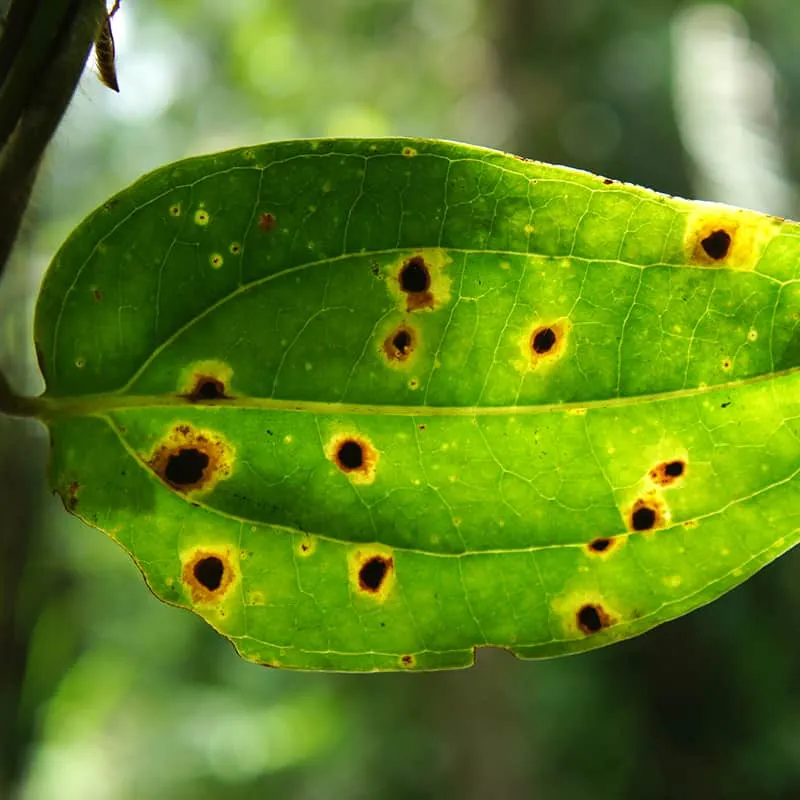

In [14]:
from IPython.display import display, Image

# Visualize the input image
test_img = "/kaggle/input/data111/septoria_leaf.png"
display(Image(filename=test_img))
